# Prototype Version 4
This code will read data from an tsv file, this file contains associations of the name of a tandem spectra and their corresponding amino acids sequence. I will find the corresponding spectra in an mzML file and create a Dataframe from matches.
<br>
This code will then find the shortest spectra <b>visualize</b> it and <b>identify</b> the presumably correct peaks based on the match.
This programs purpose is to recreate this spectra annotation as faithfully as possible just based on the distances between the peaks (which are assumed to be y-ions). The code will <b>recognize</b> amino acids that could fit in between these peaks.
<br>
This code will create a distance matrix and score every single distance between peaks and which of them could fit an amino acids or pair of amino acids between them. Using this distance matrix the code will find every single possible peptide. These are then given a confidence score referring to their likelyhood of being the true peptide. This confidence score is adapted from the 2003 paper by David Tabb named DirecTag https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2810657/
<br>
This approach of identifying peptides is called <b>DeNovo </b> and this code is based on a presentation by Nick Webb (https://www.weddslist.com/ms/tandem.html)

I will investigate how well my programs predict the amino acid sequence by comparing the actual vs predicted sequence AND how well my confidence score works.

At the end, in order to check my results, I will use the pyteomics.pylab_aux module to test my annotations and visualize the


In [1]:
import ast

# basic dependencies and useful math/organization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# to read mzML files
from pyteomics import mzml

# to visualize mzML
from pyteomics import pylab_aux as pa, usi

# to find peaks
from scipy.signal import find_peaks
from peakutils import indexes

## reading the files

In [2]:
# file that contains the associations between tandem spectra name and amino acids sequence
df = pd.read_csv("../data/psm_a.tsv", sep="\t")

In [3]:
# file that contains the amino acids and their weights
# TODO for now there is a distinction between "I" and "L"
# They are indistinguishable by weight so I cant really know which one it is
aa = pd.read_csv("../data/single_double_amino_acids.csv")

In [4]:
mz_path = '../data/2015-05-19_MRC5_a.mzML'

In [5]:
# this creates a dictionary of matches between the mzMl file and the psm_a.tsv
# this should only return MS/MS where we have the Peptide sequence already identified.
i = 0
matches = []
plotting_dict = None
with mzml.MzML(mz_path) as reader:
    for spectrum in reader:
        # looking for the first match between the 2 files
        for name in df["Spectrum"]:
            if name in spectrum.get('spectrum title') :
                # print(spectrum["index"], spectrum.get("spectrum title"))
                # Extract relevant information
                matches.append([spectrum,df[df["Spectrum"] == name]["Peptide"].sum(),
                               df[df["Spectrum"] == name]["Hyperscore"].sum()])
                """
                spectrum_name = name
                mz_array = spectrum['m/z array']
                intensity_array = spectrum['intensity array']
                precursor_mz = (spectrum['precursorList']['precursor']
                                [0]['selectedIonList']['selectedIon'][0]['selected ion m/z'])

                plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}
                """
        #         break
        # if plotting_dict != None:
        #     break
m_df = (pd.DataFrame(matches, columns=["Spectrum","Peptide","Hyperscore"])
    .sort_values(by = ["Hyperscore"], axis=0, ascending= False)
    .reset_index(drop=True))


## deciding on which Peptide sequence to use
I am going to aim for the shortest one for simplicity

In [6]:
print(min(m_df["Peptide"], key = len))
print(m_df[m_df["Peptide"] == str(min(m_df["Peptide"], key = len))])
pep_loc = 7103

HELIEFR
                                               Spectrum  Peptide  Hyperscore
7103  {'index': 11186, 'id': 'controllerType=0 contr...  HELIEFR      22.679


In [7]:
# collecting the data in variables
peptide = m_df["Peptide"].iloc[pep_loc]
print("Peptide sequence:", peptide)
mz_array = m_df["Spectrum"].iloc[pep_loc]['m/z array']
intensity_array = m_df["Spectrum"].iloc[pep_loc]['intensity array']
precursor_mz = m_df["Spectrum"].iloc[pep_loc]['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z']
plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}


Peptide sequence: HELIEFR


## Finding Peaks
using sci_peak

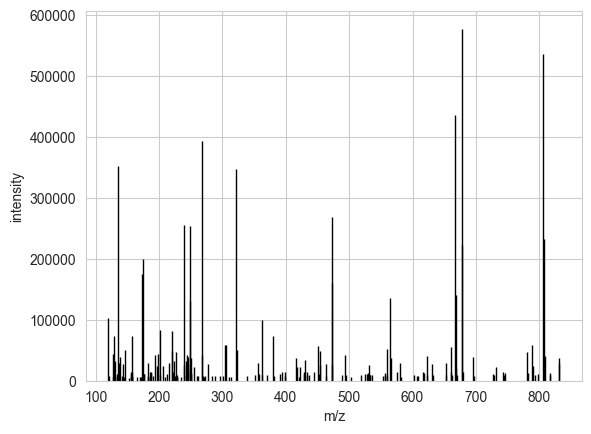

<Figure size 1200x600 with 0 Axes>

In [8]:
s1 = pd.DataFrame(plotting_dict)
pa.plot_spectrum(plotting_dict)
plt.figure(figsize=(12,6))
plt.show()

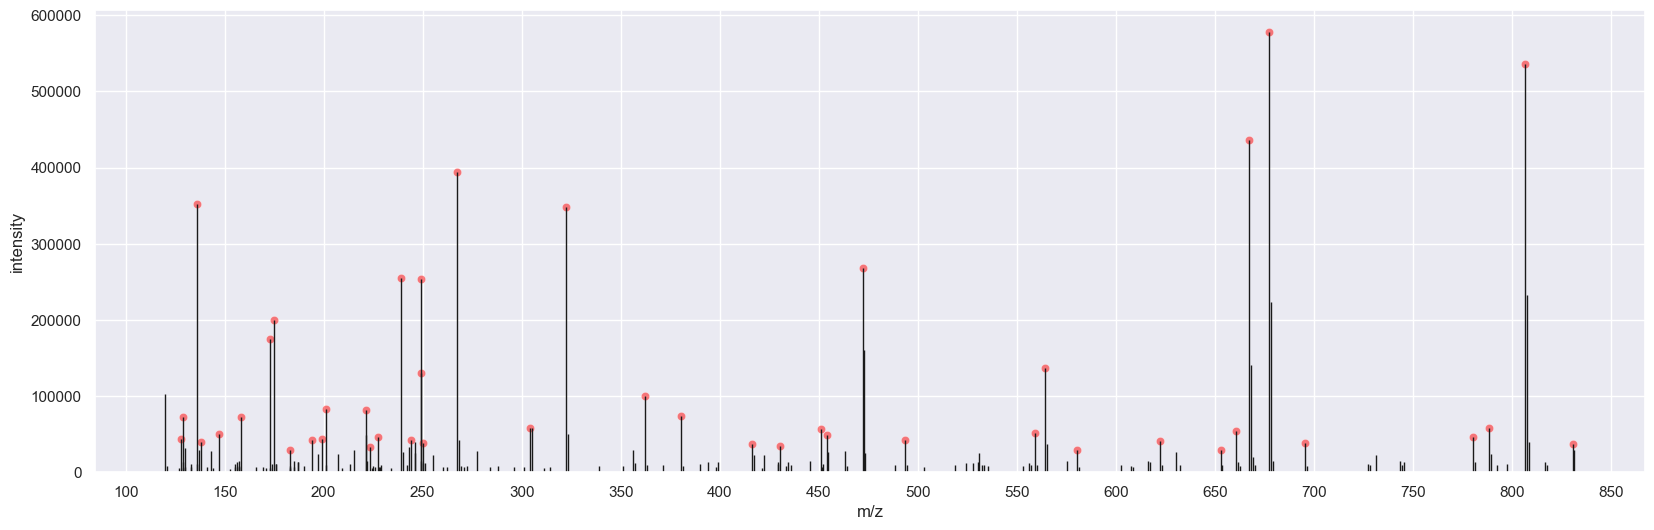

In [9]:
sp_height = intensity_array.max()*0.05
sp_dist = None
sp_prom = None
#TODO find ways to optimize for these parameters, possible based on characteristics of each spectrum
# 5% of max height should be the cutoff threshold
# i.e.: based on how long we expect the amino acid sequence to be
# what determines wheter a peak is useful, is there someway we can find out?
#

sci_peak, _ = find_peaks(s1["intensity array"],
                      height=sp_height,
                      distance=sp_dist,
                      prominence=sp_prom
                      )
sns.set_theme(rc={'figure.figsize':(20,6)})
sns.scatterplot(data = s1.iloc[sci_peak].reset_index(),
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5).set_xticks(np.arange(0,1200,50))
pa.plot_spectrum(plotting_dict)
#plt.plot(np.zeros_like(x), "--", color="gray")
#plt.figure(figsize=(12,6))
plt.show()

## automatically annotating the spectra with pyteomics
based on the "real" peptide

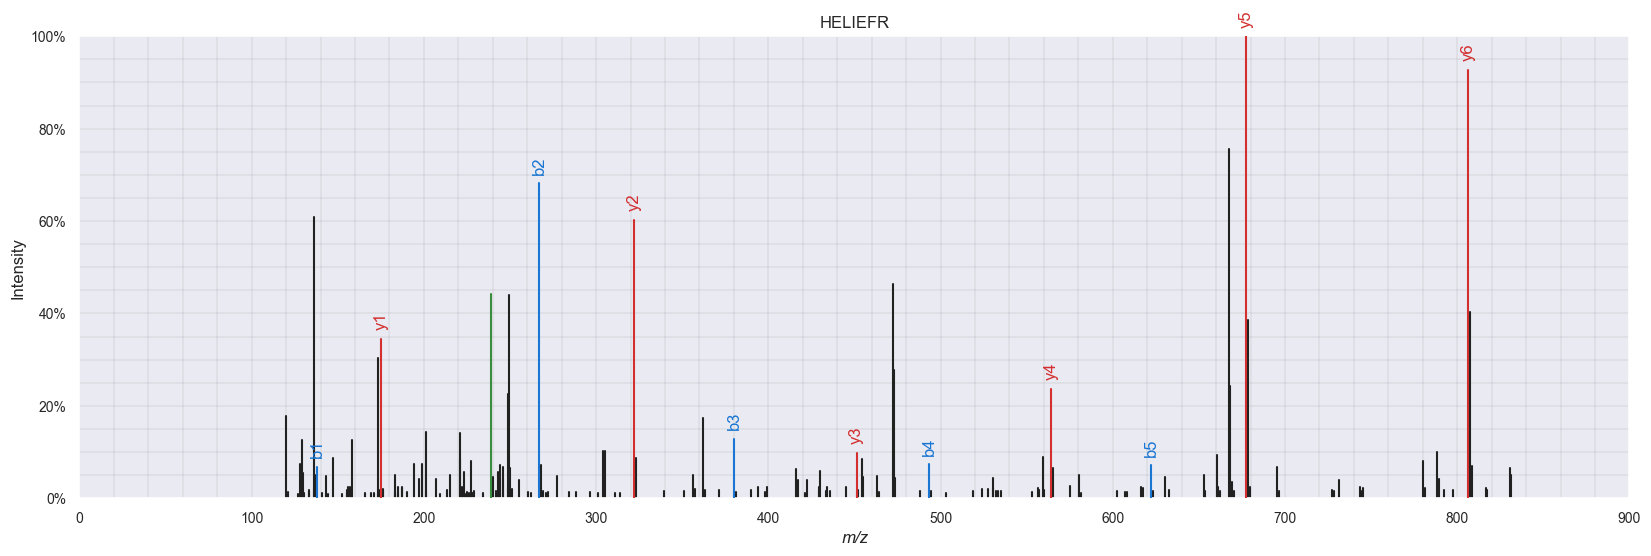

7

In [10]:
pa.annotate_spectrum(plotting_dict, peptide, precursor_charge=2, backend='spectrum_utils',
    ion_types='aby', title=peptide)
#plt.figure(figsize=(12,6))
plt.show()
len(peptide)

In [11]:
# TODO automate this thingie somehow pleeeasssee I had to read this out and validate manually
# problem is that pyteomics doesnt give me access to this thingie
# ChatGPT gave me a possible solution for it
HELIEFR_real_peptide = [["H","E","L","I","E","F","R"],[944.510392,806.44043, 677.398987, 564.313843, 451.228271, 322.187408, 175.119186, 19]]


In [12]:
806.44043 - 677.398987

129.04144299999996

In [13]:
# intensity = intensity_peaks[np.where(mz_round == 677.398987 )[0][0]]
# np.where(ranked_intensity == intensity)[0][0] + 1

## Function for finding the closes amino acids

In [14]:
# cheesing an issue with the apply function
# TODO pass this as an argument for the function instead of letting it access an outside variable
combo_df = aa

In [15]:
import math
def find_closest_aa(value, thres = 2.5):
    """ Find the closest amino acid to a given mass.
    this code takes a dataframe with single amino acids and combinations of amino acids in this format

        full    letter  short   comp    mono    mass    G           A           S           P   V etc.
    0   glycine G       gly     c2h3no  57      57      g+g mass    g+a mass    g+s mass
    1   alanine A       ala     c3h5no  71      71      a+g mass    a+a mass    a+s mass
    etc.

    using this dataframe and a given mass, it will find the closest amino acid
     or combination of 2 amino acids to the given mass.
    It will only return amino acids that are within the threshold.
    It returns a list of lists, where each list contains the letter of the amino acid, its mass and the error.
    """
    # TODO remove useless calculations from this like closeness_list having values that I never use
    if math.isnan(value) == True:
        return None
    single_df = combo_df.iloc[:,:-22]
    double_df = combo_df.set_index(["letter"]).iloc[
                :,[i for i in range(-22, -0)]]
    closeness_list = []
    # find the closest single amino acids
    loop_for_single = True
    while loop_for_single:
        aam_array = np.asarray(single_df["mono mass"])
        idx = (np.abs(aam_array - value)).argmin()
        error = np.abs(aam_array[idx] - value)
        if error > thres:
            loop_for_single = False
        else:
            name_idx = single_df["letter"].iloc[idx]
            closeness_list.append([name_idx, aam_array[idx], error])
            single_df = single_df.drop(single_df.index[idx])
    # find closest combination of amino acids
    loop_for_combo = True
    while loop_for_combo:
        error = (np.abs(double_df - value)).min().min()
        r, c = np.where(double_df == error + value)
        # if error wouldve been negative np.where will not find r, c
        # and pass empty arrays creating error
        if r.size == 0 :
            # print("boink")
            r, c = np.where(double_df == value - error)
        if error > thres:
            loop_for_combo = False
        else:
            # TODO resolve the issue of the +
            name_idx = double_df.index[r[0]]+ double_df.columns[c[0]]
            closeness_list.append([name_idx, double_df.iloc[r[0],c[0]], error])
            double_df.iloc[r[0],c[0]] = None
    # print("closest aa is: ", name_idx, " ,with mass: ",
    # aam_array[idx], "Da. With an error of: ", error, "Da.")
    closeness_list.sort(key=lambda x: x[2])
    if closeness_list:
        # return closeness_list[0]
        return closeness_list[0][0]
    return None


'''
I would love to decided a closeness factor by iterating over the weights
and seeing how close they are to each other on average. Does this make sense?
'''

'\nI would love to decided a closeness factor by iterating over the weights\nand seeing how close they are to each other on average. Does this make sense?\n'

# Creating the distance Matrix

In [16]:
mz_peaks = mz_array[sci_peak]
intensity_peaks = intensity_array[sci_peak]
# the precursor mass is not in the original mz_array or intensity_array dataset
# but since we know the precursor mass from the MS1 adding it makes our search easier
mz_peaks = np.append(mz_peaks,precursor_mz*2)
# I made the intensity of the manually added precursor max+1 so its the higest in the ranking
# this is because I think its always going to be part of the protein
intensity_peaks = np.append(intensity_peaks, intensity_peaks.max()+1)
# then another addition because at the C-terminus there is a water molecule and an extra proton
# it can be difficult to identify the last amino acid without using a little trick
# I will add another artificial peak at 19 Da to which the program can find a connected amino acid.
# TODO ask Peter or Kristoffer if this is a good idea
mz_peaks = np.append(19, mz_peaks)
# I had to append something at the 0th index and I choose the mean intensity
# because I believed this wouldnt upset the ranking too much
# TODO ask Peter or Kristoffer if it wouldnt be smart to just add max+1 here too
# because the 19 Daltons should also always be there
intensity_peaks = np.append(intensity_peaks.mean(),intensity_peaks)
mz_round = np.round(mz_peaks, decimals= 6)

In [17]:
# on my stackoverflow someone suggested a better way to create my distance matrix
# however I am now so deep in this going back would cost too much time

# this code builds a distance matrix for the given mz_array
# unless there is already a file in the directory it can just read

def rename(column):
    new = mz_round[int(column)]
    return new

try:
    # I made the try and except and the whole program used to depend on having the matrix be read from a dataframe
    # no I rarely ever use it tho so maybe it can be thrown out
    # I want to think about the implications first tho and not ruin a working flow
    df_aa = NONEpd.read_csv("below_shortest_example_matrix_named.csv").set_index("Unnamed: 0")
except:
    distance_matrix = []
    for column, i in zip(mz_round, range(len(mz_round))):
        distance_matrix.append([])
        for row in mz_round:
            distance_matrix[i].append(np.abs(row - column))

    df_dm = pd.DataFrame(distance_matrix)
    df_dm.columns = df_dm.columns.map(str)

    # for i in range(len(mz_round)):
    #     for j in range(i):
    #         df_dm.iat[i,j] = None
    for i in range(len(mz_round)):
        for j in range(len(mz_round)):
            if j >= i:
                df_dm.iat[i,j] = None
            if df_dm.iat[i,j] < 55 or df_dm.iat[i,j] > 480:
                df_dm.iat[i,j] = None

    # if j <= i:
    #     df_dm.iat[i,j] = None
    # drop columns with no values (all NaN)
    df_dm.dropna(axis = 1, how="all", inplace = True)

    print("starting mapping")
    df_aa = df_dm.map(find_closest_aa)
    print("mapping complete")

    df_aa.rename(columns=rename, inplace=True)
    df_aa.rename(index=rename, inplace=True)

    df_aa.to_csv("below_shortest_example_matrix_named.csv")

    #have to reread so dictionaries are reconverted into strings
    # this is stupid but makes the code work consistently with read csv files
    df_aa = pd.read_csv("below_shortest_example_matrix_named.csv").set_index("Unnamed: 0")


starting mapping
mapping complete


## function to find all possible paths through this distance matrix

In [18]:
# TODO give this function somehow sensible arguments to pass
# kids look away this function is not greatly formatted
def find_all_paths(n = 1000):
    # This is written to work form the highest peak down to the lowest similar to how its done by nick wedd.
    # however my distance matrix removed all points below the diagonal meaning anytime I identify a hit of an amino acid it looks like follows
    # hit a row: x and column: y. where y > x and since my program iterates over rows and then columns it sets the column to be the new row.
    # which means it starts back at the top and repeats itself in a pattern. Ill have to change the orientation of the matrix.
    full_pep_list = []

    blacklist = []

    # TODO IMPORTANT ACTUALLY need to change this so it doesnt range to n but rather gathers every possible peptide, possible in the 100.000
    for j in range(n):
        path_one = []
        peaks_one = []
        cur_peak = float(mz_round[-1])
        # precursor in this dataset isnt in mz_round
        #
        while cur_peak > float(mz_round[0]):
            found = False
            for column in reversed(df_aa.columns):
                # print("conk", type(aa))
                peak_pos = np.where(mz_round == cur_peak)[0][0]
                aa_inf = df_aa[column].iloc[peak_pos]#.values[0]
                aa_int = intensity_peaks[peak_pos]
                # print("row:",mz_round[peak_pos],"column: ", column,"aa:",aa_inf,"int:",aa_int)
                #time.sleep(0.1)
                # choosing the first possible connection always as of now
                if isinstance(aa_inf, str) and peaks_one + [mz_round[peak_pos], float(column)] not in blacklist:
                    # and peaks_one not in blacklist:# or float(column) not in Xblacklist):
                    # print("\n boingoloingo \n",mz_round[peak_pos],"\n",column," \n")
                    found = True
                    # if peaks_one + [mz_round[peak_pos], float(column)] in blacklist:
                    #     found = False
                    #     print("WE HAVE BEEN DOWN THIS PATH BEFORE, ABORT MISSION AJDKSDFSDKFJ")
                    #     break
                    path_one.append(aa_inf)
                    peaks_one.append(mz_round[peak_pos])
                    #peaks_one.append(mz_round[peak_pos])
                    # ast.literal_eval is a security risk but I dont know a better way
                    # Problem is that dictionaries get saved as string when .to_csv is applied
                    cur_peak = float(column)
                    last_peak = float(column)
            if not found:
                # print("skip to next row")
                cur_peak = float(mz_round[peak_pos-1])
                found = False

        peaks_one.append(last_peak)
        blacklist.append(peaks_one)
        # info_dic = {}
        # for i in range(len(peaks_one)):
        #     info_dic[i] = peaks_one[i]
        full_pep_list.append([path_one, peaks_one])
        # print("new peptide finished")
        #print(path_one)
        print(j)

    return full_pep_list

In [19]:
# TODO find a way to get every paths by having a good termination condition
HELIEFR_pep_list = find_all_paths(20000)

new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide finished
new peptide f

In [20]:
pep_df = pd.DataFrame(HELIEFR_pep_list, columns = ["sequence","peaks"])
# TODO + problem occurs here again. cant differentiate between aa and pair of aa
pep_df['len_pep'] = pep_df["peaks"].str.len()
pep_df.sort_values(by='len_pep', ascending=False)

,sequence,peaks,len_pep
0,"[N, H, A, G, A, L, G, G, A, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12
2691,"[N, H, A, G, A, A, G, G, G, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12
6792,"[N, H, A, G, S, A, G, G, G, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12
2642,"[N, H, A, G, A, A, G, G, A, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12
6808,"[N, H, A, G, S, A, G, G, G, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12
...,...,...,...
19543,"[N, H, A, UY]","[944.510392, 830.4599, 695.33606, 580.275269, ...",5
19542,"[N, H, A, EF]","[944.510392, 830.4599, 695.33606, 580.275269, ...",5
19541,"[N, H, A, EE]","[944.510392, 830.4599, 695.33606, 580.275269, ...",5
19540,"[N, H, A, AF]","[944.510392, 830.4599, 695.33606, 580.275269, ...",5


In [21]:
# TODO find a way to compute every single possible peptide
# this will create soooo many peptides tho
# TODO implement the DirecTag ranking methods.
# TODO is there a heuristic for this???
# like can I find a way to know ahead of time which path makes the most sense

## implement confidence scoring function

### 1st intensity subscore or intensity rank sum

In [22]:
ranked_intensity = np.flip(np.sort(intensity_peaks))

In [23]:
# testing
i = 830.4599
intensity = intensity_peaks[np.where(mz_round == i)[0][0]]
print(intensity, np.where(ranked_intensity == intensity)[0][0])

37529.8203125 39


In [24]:
# TODO add sensible arguments for the function so it doesnt depend on outside variables

def intensity_rank(peaks_list):
    rank_sum = 0
    for i in peaks_list:
        intensity = intensity_peaks[np.where(mz_round == i)[0][0]]
        # I added the + 1 so that the best rank is 1
        # I did this because the ChatGPT code did this too and I didnt want to mess it up lol
        # print(intensity, np.where(ranked_intensity == intensity)[0][0])
        rank_sum += np.where(ranked_intensity == intensity)[0][0] + 1
    return rank_sum

In [25]:
HELIEFR_real_peptide
real_rank_sum = intensity_rank(HELIEFR_real_peptide[1])

In [26]:
rank_sum = intensity_rank(HELIEFR_pep_list[0][1])
real_rank_sum = intensity_rank(HELIEFR_real_peptide[1])

In [27]:
real_rank_sum

75

In [109]:
# now I need to find a way how to relativise the rank_sum since its going to be different
# david tabb has a stochastic way to do this, i just need to find out how to implement it whoooppssieees

# Chat GPT generated idea

import random

# IMPORTANT T has to be the exact length of the peptide so ill have to sort my fina_pep_list by length of observation and calculate a distribution of each one
# meaning it would be nice for me to find a heuristic to see how long the peptide likely is based on the MS/MS
# because I could get a "super good fit" but it might find a peptide that is 3 long where the actual is 9 yknow.
def simulate_rank_sum_distribution(N, T, num_samples=10000):
    rank_sums = []
    ranks = list(range(1, N+1))
    for _ in range(num_samples):
        sample = random.sample(ranks, T)
        rank_sums.append(sum(sample))
    return rank_sums

def empirical_p_value(observed_sum, distribution):
    # Probability of getting an equal or smaller sum by chance
    count = sum(1 for s in distribution if s <= observed_sum)
    # print(len(distribution))
    return count / len(distribution)


In [94]:
# creating random rank distributions for each observed peptide length in the dataset
pep_lens_in_list = range(pep_df["len_pep"].min(),pep_df["len_pep"].max()+1)
rank_distributions = {}
for T in pep_lens_in_list:
    rank_distributions[T] = simulate_rank_sum_distribution(len(intensity_peaks), T)

In [95]:
# more chat gpt stuff where its testing

N = len(intensity_peaks)
T = len(HELIEFR_real_peptide[0])

distribution = rank_distributions[len(HELIEFR_pep_list[0][0])]
p_value = empirical_p_value(real_rank_sum, rank_distributions[len(HELIEFR_real_peptide[0])])

p_value

10000


0.003

In [31]:
# applying the intensity rank functions to the entire dataframe
pep_df["rank_sum"] = pep_df["peaks"].apply(intensity_rank)
pep_df["rank_p"] = pep_df.apply(
lambda row: empirical_p_value(row["rank_sum"], rank_distributions[row["len_pep"]]),
axis=1
)
# pep_df.drop(columns="rank_sum", inplace=True)


In [32]:
pep_df["peaks"].iloc[1]

[944.510392,
 830.4599,
 695.33606,
 622.31842,
 564.313843,
 493.277924,
 380.192444,
 322.187408,
 267.108826,
 194.091873,
 138.066132]

In [33]:
pep_df.drop_duplicates(["peaks"])

,sequence,peaks,len_pep,rank_sum,rank_p
0,"[N, H, A, G, A, L, G, G, A, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12,246,0.1838
1,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,264,0.5580
2,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,233,0.2647
3,"[N, H, A, G, A, L, G, G, A, SS]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,240,0.3260
4,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,271,0.6281
...,...,...,...,...,...
19995,"[N, H, A, A, L, G, G, AH]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,207,0.4579
19996,"[N, H, A, A, L, G, G, S, D]","[944.510392, 830.4599, 695.33606, 564.313843, ...",10,227,0.4235
19997,"[N, H, A, A, L, G, G, S]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,245,0.8326
19998,"[N, H, A, A, L, G, G, S]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,214,0.5358


### 2nd m/z fidelity

In [34]:
# did not think I would be done with rank sum intensity this quickly lol but it seems to work good haha
# we mooovvveee
# TODO here we run into the + problem mentioned above
# since we have the pair of amino acids fitting inbetween peaks we have less peaks for the same amount of amino acids
# usually we have len(sequence) = len(peaks) - 1. But now it can be - 2 or - 3 or more.
# why is this a problem. Well it already is a small problem with intensity rank sum since a longer peptide with less peaks identified is going to have a smaller rank_sum score than the potentially same peptide with all peaks identified. Therefore the system is going to favor the less identified peptide and thats just stupid. I need to solve that issue rn.
# TODO add 1 to the pep_len if there is a plus in sequence (does that make sense?)
#

In [108]:
def find_SSE(sequence, peaks):
    # find the m/z fidelity from the first peak to the last
    # important here our first peak is the first y-ion so its already missing the first peptide
    estimation = []
    distance = 0
    for i in range(1,len(sequence)):
        distance += aa[aa["letter"]==sequence[-i]]["mono mass"].sum()
        estimation.append(peaks[-(i+1)] - distance)
        mean = np.mean(estimation)
        # print(mean)
        SSE = (estimation - mean)**2
    # print(estimation)
    # print(SSE)
    return SSE.sum()

In [36]:
# sequence = HELIEFR_pep_list[0][0]
# peaks = HELIEFR_pep_list[0][1]

sequence = HELIEFR_real_peptide[0]
peaks = HELIEFR_real_peptide[1]

# sequence, peaks
find_SSE(sequence, peaks)

3.662954303028436e-06

In [37]:
pep_df["SSE"] = pep_df.apply(
lambda row: find_SSE(row["sequence"], row["peaks"]),
axis=1
)

In [38]:
pep_df.head()

,sequence,peaks,len_pep,rank_sum,rank_p,SSE
0,"[N, H, A, G, A, L, G, G, A, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12,246,0.1838,17.431934
1,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,264,0.5580,12.020424
2,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,233,0.2647,12.020424
3,"[N, H, A, G, A, L, G, G, A, SS]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,240,0.3260,12.020424
4,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,271,0.6281,151.161244


In [137]:
# I am struggeling to find a way how to turn this into a p-value
# I know ill have to make a random distribution of SSE values from a randomized dataset with the same amount of peaks

def find_aa_in_list(peak_list):
    prev_peak = peak_list[1]
    for peak in peak_list[1:]:
        aa = find_closest_aa(prev_peak-peak, thres= 100)
        print(aa)

def create_SSE_dist(n):
    SSE_distributions = {}
    for T in pep_lens_in_list:
        mz_fid_dis = pep_df[pep_df["len_pep"] == T]["SSE"].to_list()
        #print(mz_fid_dis)
        if len(mz_fid_dis) > 6*n:
            SSE_distributions[T] = np.random.choice(mz_fid_dis, 6*n)
        elif len(mz_fid_dis) > 5*n:
            SSE_distributions[T] = np.random.choice(mz_fid_dis, 5*n)
        elif len(mz_fid_dis) > 3*n:
            SSE_distributions[T] = np.random.choice(mz_fid_dis, 3*n)
        elif len(mz_fid_dis) > 2*n:
            SSE_distributions[T] = np.random.choice(mz_fid_dis, 2*n)
        elif len(mz_fid_dis) > n:
            SSE_distributions[T] = np.random.choice(mz_fid_dis, n)
        else:
            SSE_distributions[T] = []
    return SSE_distributions

In [138]:
create_SSE_dist(1000)

{5: [],
 6: [],
 7: array([31913.6908113 , 41639.58209989, 40297.04395734, ...,
        17601.3192808 , 15801.80514489, 81625.33779619]),
 8: array([46718.29949065, 20817.689928  , 77362.68820953, ...,
        86702.65865027, 24098.61520509, 21521.24389278]),
 9: array([24686.70199543,  4084.47327657, 15707.31851053, ...,
        34187.55401341,  3266.93573238,  6564.33678994]),
 10: array([14284.72376316,  7452.09190066, 21045.35588455, ...,
         5864.94559927, 32352.37295724, 14071.23697129]),
 11: [],
 12: []}

In [143]:
# I am struggeling to find a way how to turn this into a p-value
# I know ill have to make a random distribution of SSE values from a randommized dataset with the same amout of peaks
# which I am basically kinda doing with my dataset anyway right?
# so I think ill just use the actual dataset as an example dataset???
# TODO ask if this is not stupid practice!!!!
# TODO NO THIS DOES NOT WORK. The distribution then favours the more prominent peptide lengths which is not what I want NONONONONO
# now I normalized it tho by giving every distribution 1000 values
# because it creates an even distribution instead of like a gaussian adjecent one
# TODO mention as a limitation

SSE_distributions = create_SSE_dist(1000)
def find_mz_fid_p(row):
    # print(row["SSE"])
    count = sum(1 for s in SSE_distributions[row["len_pep"]] if s <= row["SSE"])
    # print(count)
    # print(row["SSE"])
    # print(count, len(mz_fid_dis))
    return ((count / len(distribution)) * 10) + 0.0001

In [128]:
find_mz_fid_p(pep_df.iloc[500])

0.274

In [144]:
# apply mz fidelity to dataframe
pep_df["mz_fid_p"] = pep_df.apply(
lambda row: find_mz_fid_p(row),
axis=1
)

In [145]:
pep_df

,sequence,peaks,len_pep,rank_sum,rank_p,SSE,mz_fid_p
0,"[N, H, A, G, A, L, G, G, A, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12,246,0.1838,17.431934,0.0001
1,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,264,0.5580,12.020424,0.0001
2,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,233,0.2647,12.020424,0.0001
3,"[N, H, A, G, A, L, G, G, A, SS]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,240,0.3260,12.020424,0.0001
4,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,271,0.6281,151.161244,0.0001
...,...,...,...,...,...,...,...
19995,"[N, H, A, A, L, G, G, AH]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,207,0.4579,8920.311517,0.9541
19996,"[N, H, A, A, L, G, G, S, D]","[944.510392, 830.4599, 695.33606, 564.313843, ...",10,227,0.4235,11351.731058,1.0951
19997,"[N, H, A, A, L, G, G, S]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,245,0.8326,9295.758749,0.9971
19998,"[N, H, A, A, L, G, G, S]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,214,0.5358,9295.758749,0.9971


## asses and combine confidence scores

In [146]:
from scipy.stats import chi2
# code generated by chatGPT
def fisher_combined_p(p1, p2):
    """
    Combine two p-values using Fisher's method.
    """
    chi_stat = -2 * (math.log(p1) + math.log(p2))
    combined_p = chi2.sf(chi_stat, df=4)  # df = 2 * number of p-values
    return combined_p

In [147]:
# assesing the real peptide
HELIEFR_real_peptide
real_rank_sum = intensity_rank(HELIEFR_real_peptide[1])
rank_p_value = empirical_p_value(real_rank_sum, rank_distributions[len(HELIEFR_real_peptide[0])])

real_SSE = find_SSE(HELIEFR_real_peptide[0], HELIEFR_real_peptide[1])
real_mz_fid_p = find_mz_fid_p({"len_pep": len(HELIEFR_real_peptide[1]),"SSE": real_SSE })

print(rank_p_value)
fisher_combined_p(rank_p_value, real_mz_fid_p)

0.003


4.805845008687067e-06

In [148]:
pep_df["combined_p"] = pep_df.apply(
lambda row: fisher_combined_p(row["rank_p"],row["mz_fid_p"]),
axis=1
)

In [226]:
pep_df

,sequence,peaks,len_pep,rank_sum,rank_p,SSE,mz_fid_p,combined_p
0,"[N, H, A, G, A, L, G, G, A, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12,246,0.1838,17.431934,0.0001,0.000219
1,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,264,0.5580,12.020424,0.0001,0.000602
2,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,233,0.2647,12.020424,0.0001,0.000305
3,"[N, H, A, G, A, L, G, G, A, SS]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,240,0.3260,12.020424,0.0001,0.000369
4,"[N, H, A, G, A, L, G, G, A, G]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,271,0.6281,151.161244,0.0001,0.000671
...,...,...,...,...,...,...,...,...
19995,"[N, H, A, A, L, G, G, AH]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,207,0.4579,8920.311517,0.9541,0.798661
19996,"[N, H, A, A, L, G, G, S, D]","[944.510392, 830.4599, 695.33606, 564.313843, ...",10,227,0.4235,11351.731058,1.0951,0.820119
19997,"[N, H, A, A, L, G, G, S]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,245,0.8326,9295.758749,0.9971,0.984688
19998,"[N, H, A, A, L, G, G, S]","[944.510392, 830.4599, 695.33606, 564.313843, ...",9,214,0.5358,9295.758749,0.9971,0.869164


## distribution of confidence scores

In [164]:
pep_df.sort_values(by=["combined_p"], ascending=False)["combined_p"]
pep_df.sort_values(by=["combined_p"], ascending=False).reset_index().index

RangeIndex(start=0, stop=20000, step=1)

### original distribution

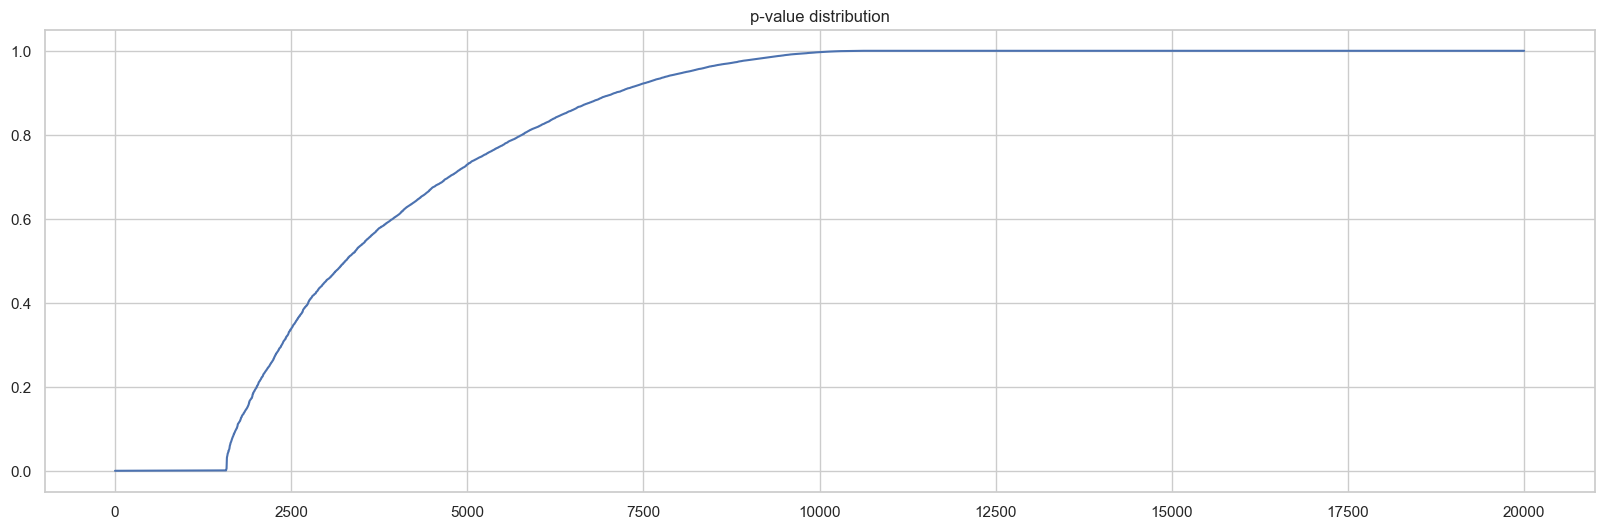

In [229]:
###
p_dist_data = {
    "x":pep_df.sort_values(by=["combined_p"], ascending=True).reset_index().index,
    "y":pep_df.sort_values(by=["combined_p"], ascending=True).reset_index()["combined_p"]
}

over_001_df = pep_df.sort_values(by=["combined_p"], ascending=True).reset_index()
over_001_df = over_001_df[over_001_df["combined_p"] > 0.01]


over_001 = {
    "x": over_001_df.index,
    "y": over_001_df["combined_p"]
}


plt.plot(
    p_dist_data["x"],p_dist_data["y"]
)
plt.title("p-value distribution")
# plt.xlim(0,1500)
# plt.ylim(-0.005,0.005)
#plt.gca().invert_yaxis()

# plt.savefig('../graphs/p_score_dist.png')
plt.show()

### -log(y) over 0.01

Text(0.5, 1.0, '-log(y) of p values over 0.01')

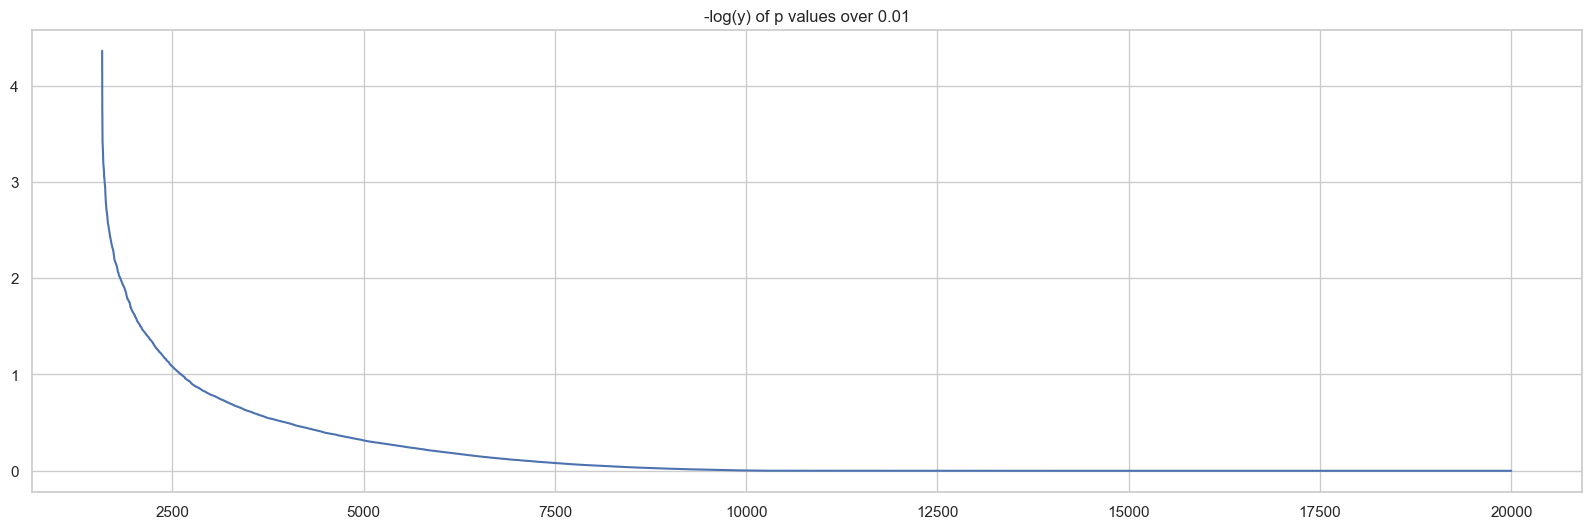

In [228]:
plt.plot(
    over_001["x"],
    -np.log(over_001["y"])
)
plt.title("-log(y) of p values over 0.01")

### first derivatve original

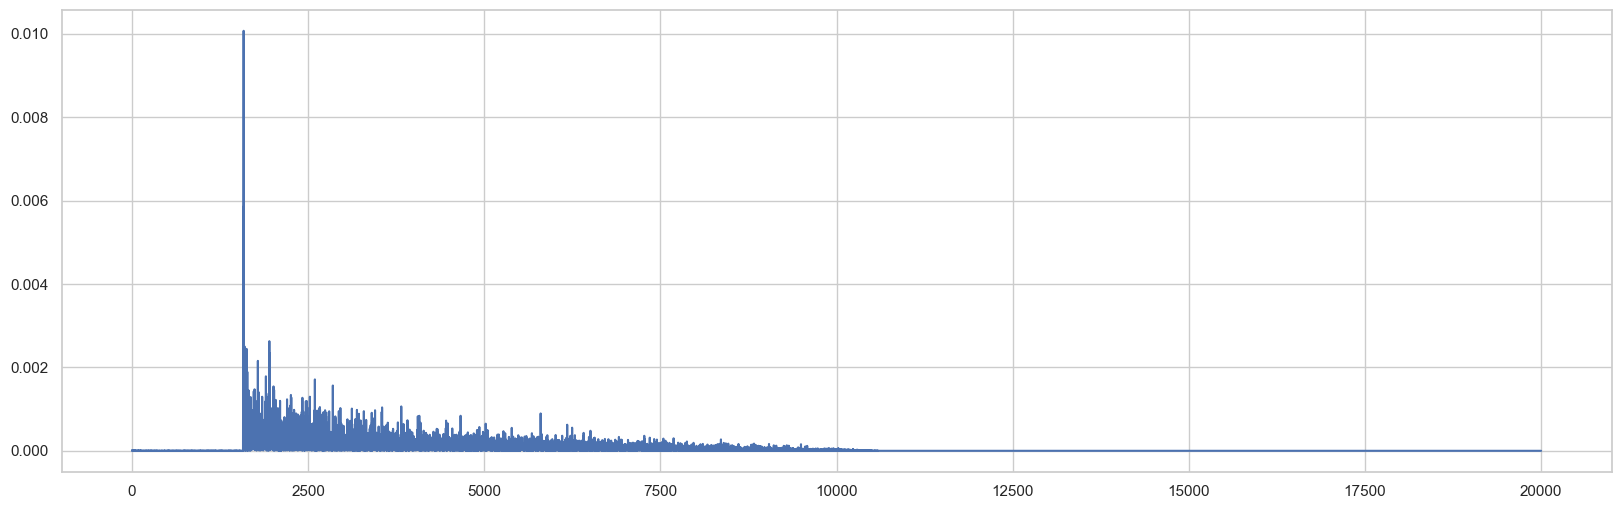

In [204]:
plt.plot(
    p_dist_data["x"][0:-1],
    np.diff(p_dist_data["y"])
)


### second derivative original

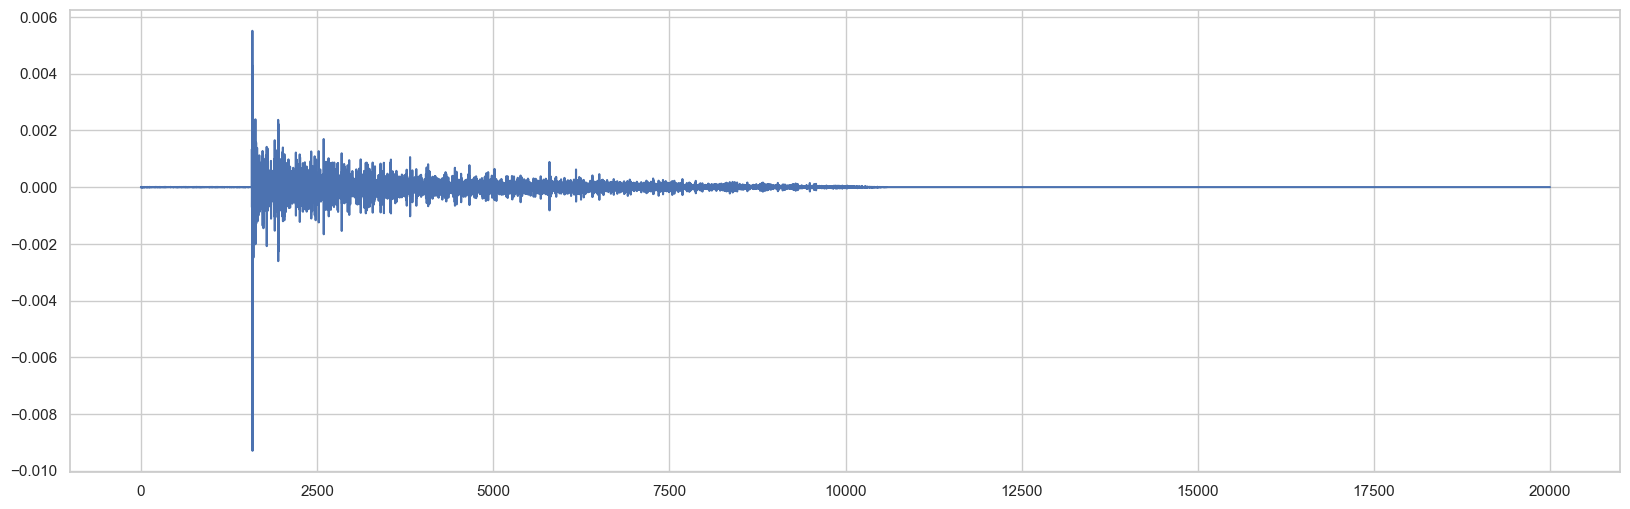

In [205]:
plt.plot(
    p_dist_data["x"][0:-2],
    np.diff(np.diff(p_dist_data["y"]))
)

### first derivative -log(y)

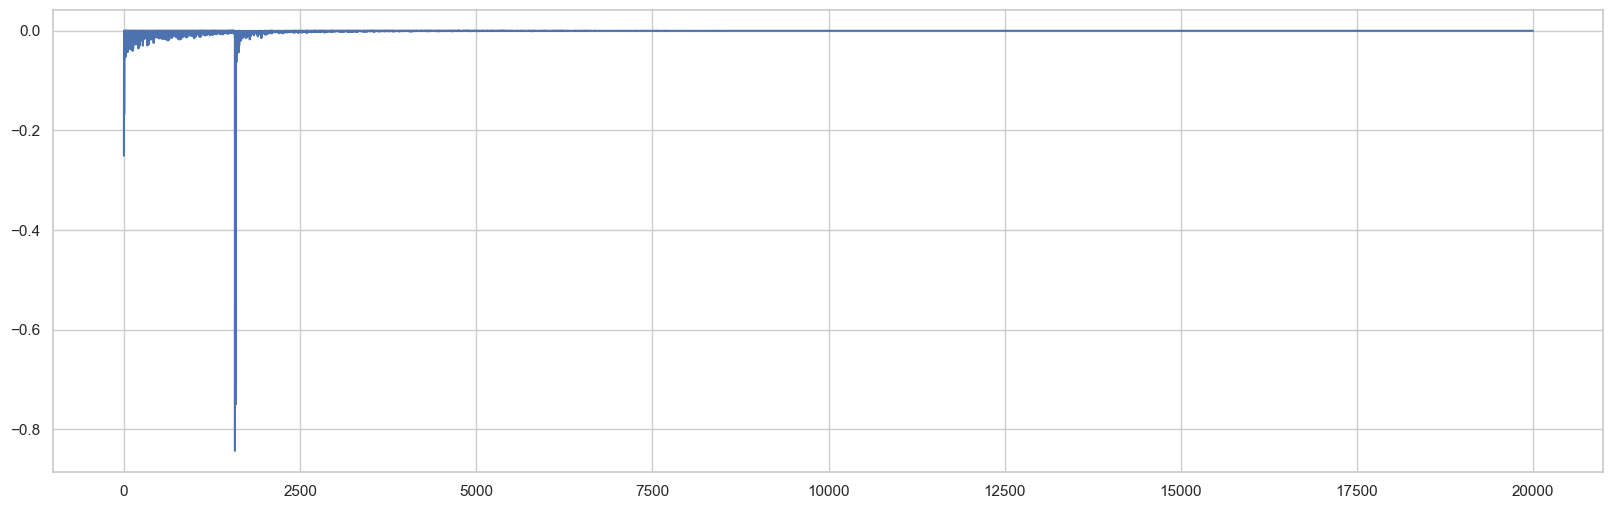

In [215]:
plt.plot(
    p_dist_data["x"][0:-1],
    np.diff(-np.log(p_dist_data["y"]))
)

### second derivative -log(y)

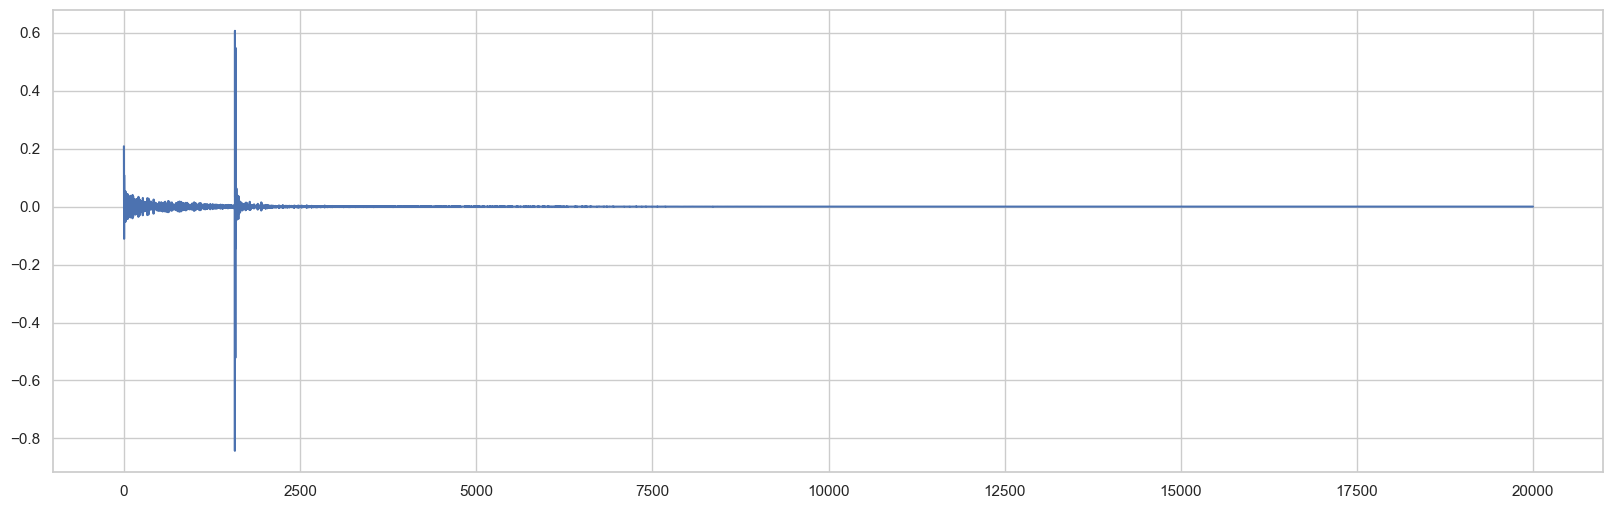

In [217]:
plt.plot(
    p_dist_data["x"][0:-2],
    np.diff(np.diff(-np.log(p_dist_data["y"])))
)

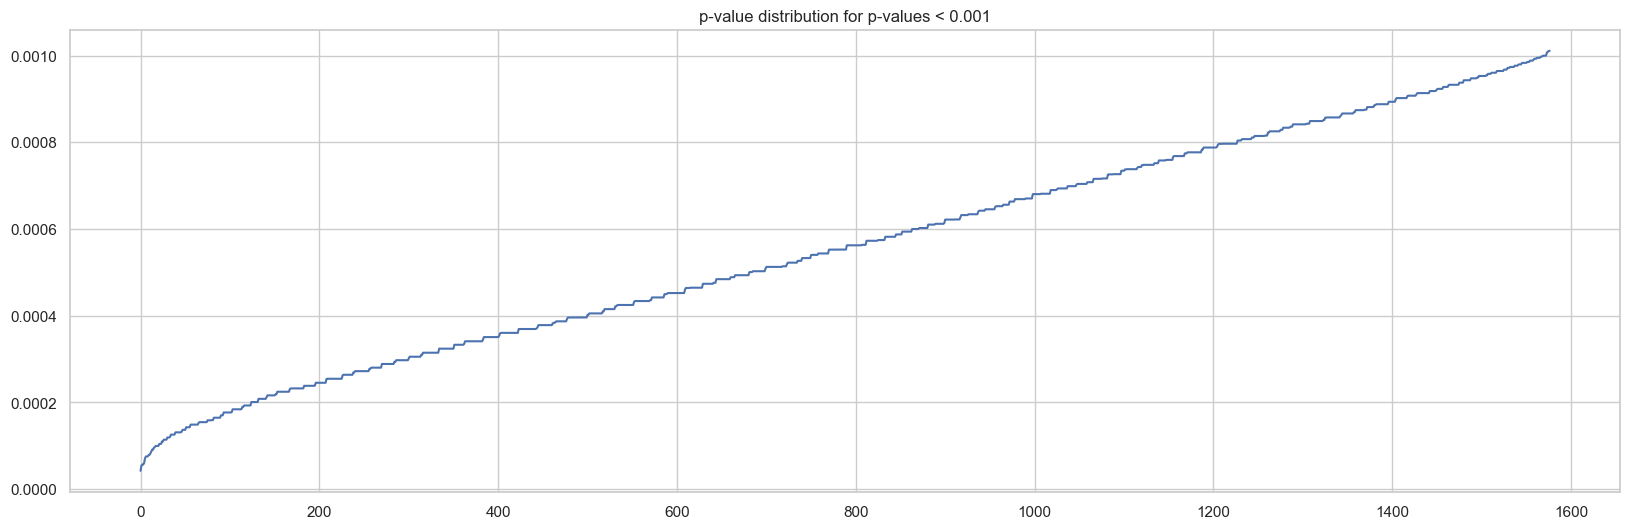

In [230]:
sorted_p_df = pep_df.sort_values(by=["combined_p"], ascending=True).reset_index()
sorted_p_df = sorted_p_df[sorted_p_df["combined_p"] < 0.002]

plt.plot(
    sorted_p_df.index,
    sorted_p_df["combined_p"]
)
plt.title("p-value distribution for p-values < 0.001")

#plt.gca().invert_yaxis()
plt.show()

In [232]:
best_50_df = sorted_p_df[0:50]
best_50_df

,index,sequence,peaks,len_pep,rank_sum,rank_p,SSE,mz_fid_p,combined_p
0,1260,"[N, H, A, G, A, G, G, G, A, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,187,0.0309,13176.944200,0.0001,0.000042
1,1333,"[N, H, A, G, A, G, G, G, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,191,0.0405,17477.859890,0.0001,0.000054
2,1293,"[N, H, A, G, A, G, G, G, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,192,0.0424,16660.076941,0.0001,0.000057
3,1256,"[N, H, A, G, A, G, G, G, A, R]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,192,0.0424,8141.575830,0.0001,0.000057
4,1257,"[N, H, A, G, A, G, G, G, A, GP]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,193,0.0451,8332.740219,0.0001,0.000060
5,1329,"[N, H, A, G, A, G, G, G, G, R]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,196,0.0541,11712.550750,0.0001,0.000071
6,1289,"[N, H, A, G, A, G, G, G, G, R]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,197,0.0577,10807.608529,0.0001,0.000075
7,1330,"[N, H, A, G, A, G, G, G, G, GP]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,197,0.0577,11940.930964,0.0001,0.000075
8,1309,"[N, H, A, G, A, G, G, G, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",11,197,0.0577,16664.500550,0.0001,0.000075
9,1250,"[N, H, A, G, A, G, G, G, A, G, D]","[944.510392, 830.4599, 695.33606, 622.31842, 5...",12,220,0.0604,7552.675999,0.0001,0.000079


b## visualize most confident peptide and its MS/MS